Traitement de l'image : lenna.bmp


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [4.0..242.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [4.0..242.0].


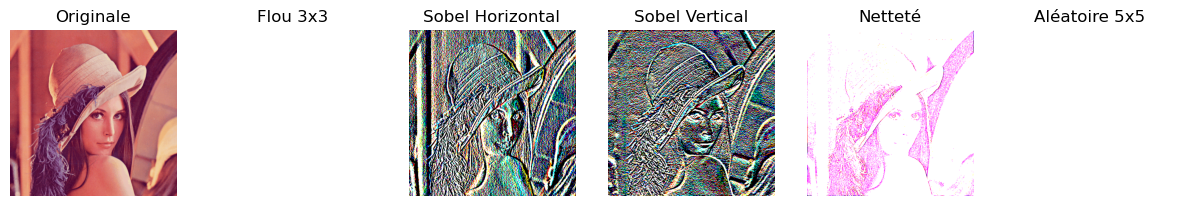

Traitement de l'image : cameraman.bmp


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [31.555555..253.88889].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [33.519325..253.13315].


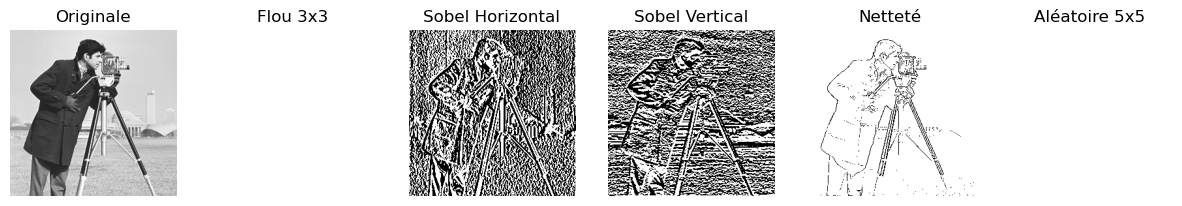

Traitement terminé !


In [7]:
             # on peut faire le Teste d’autres modes dans np.pad (. mode=’reflect’ ou mode=’wrap’)

import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# Fonction pour charger une image (grayscale ou RGB)
def image_load(image_path, channel=None):
    """
    Charge une image en niveaux de gris ou RGB.
    Si channel n'est pas spécifié, détecte automatiquement le type.
    """
    assert os.path.exists(image_path), f"Erreur : L'image {image_path} n'existe pas"
    
    # Charger l'image
    if channel == 1:  # Niveaux de gris
        image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        assert image is not None, "Erreur : Impossible de charger l'image en niveaux de gris"
    elif channel == 3:  # RGB
        image = cv2.imread(image_path)
        assert image is not None, "Erreur : Impossible de charger l'image RGB"
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir BGR en RGB
    else:  # Détection automatique
        image = cv2.imread(image_path)
        assert image is not None, "Erreur : Impossible de charger l'image"
        if len(image.shape) == 2:  # Grayscale
            channel = 1
        else:  # RGB
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            channel = 3
    
    return image, channel

# Fonction pour appliquer la convolution sur un canal
def convolve_channel(image, kernel):
    """
    Applique la convolution sur un canal de l'image.
    """
    # Assertions pour valider les dimensions
    assert isinstance(image, np.ndarray), "L'image doit être un tableau NumPy"
    assert isinstance(kernel, np.ndarray), "Le noyau doit être un tableau NumPy"
    assert len(kernel.shape) == 2, "Le noyau doit être une matrice 2D"
    assert kernel.shape[0] == kernel.shape[1], "Le noyau doit être carré"
    assert kernel.shape[0] % 2 == 1, "Le noyau doit avoir une taille impaire"
    assert image.shape[0] >= kernel.shape[0], "L'image est trop petite pour le noyau en hauteur"
    assert image.shape[1] >= kernel.shape[1], "L'image est trop petite pour le noyau en largeur"

    # Dimensions
    img_height, img_width = image.shape
    kernel_height, kernel_width = kernel.shape
    pad_height, pad_width = kernel_height // 2, kernel_width // 2

    # Ajouter un padding (mode constant = zéros)
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='wrap')
    output = np.zeros_like(image, dtype=np.float32)

    # Appliquer la convolution
    for i in range(img_height):
        for j in range(img_width):
            region = padded_image[i:i + kernel_height, j:j + kernel_width]
            output[i, j] = np.sum(region * kernel)

    # Vérifier que la taille de sortie correspond à l'image d'entrée
    assert output.shape == image.shape, "La taille de l'image de sortie ne correspond pas"
    return output

# Fonction pour appliquer la convolution sur une image (grayscale ou RGB)
def apply_convolution(image, kernel):
    """
    Applique la convolution sur une image (grayscale ou RGB).
    """
    assert isinstance(image, np.ndarray), "L'image doit être un tableau NumPy"
    assert isinstance(kernel, np.ndarray), "Le noyau doit être un tableau NumPy"
    assert len(kernel.shape) == 2, "Le noyau doit être une matrice 2D"
    assert kernel.shape[0] == kernel.shape[1], "Le noyau doit être carré"
    assert kernel.shape[0] % 2 == 1, "Le noyau doit avoir une taille impaire"
    assert len(image.shape) in [2, 3], "L'image doit être en niveaux de gris (2D) ou RGB (3D)"

    if len(image.shape) == 3:  # Image RGB
        assert image.shape[2] == 3, "L'image RGB doit avoir 3 canaux"
        height, width, channels = image.shape
        output = np.zeros_like(image, dtype=np.float32)
        for c in range(channels):
            output[:, :, c] = convolve_channel(image[:, :, c], kernel)
    else:  # Image grayscale
        output = convolve_channel(image, kernel)

    # Normaliser les valeurs pour éviter des dépassements
    output = np.clip(output, 0, 255)
    return output

# Fonction pour afficher plusieurs images dans une grille
def display_images(images, titles, filename=None):
    """
    Affiche une grille d'images avec leurs titres.
    """
    n = len(images)
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.title(titles[i])
        plt.imshow(images[i], cmap='gray' if len(images[i].shape) == 2 else None)
        plt.axis('off')
    if filename:
        plt.savefig(filename)
    plt.show()

# Définir les noyaux de convolution
blur_kernel_3x3 = np.array([[1/9, 1/9, 1/9],
                            [1/9, 1/9, 1/9],
                            [1/9, 1/9, 1/9]])
sobel_horizontal = np.array([[-1, 0, 1],
                             [-2, 0, 2],
                             [-1, 0, 1]])
sobel_vertical = np.array([[-1, -2, -1],
                           [0, 0, 0],
                           [1, 2, 1]])
# Filtre de netteté (exemple de Wikipédia)
sharpen_kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])
# Filtre aléatoire 3x3
np.random.seed(42)  # Pour reproductibilité
random_kernel_5x5 = np.random.rand(5, 5)
random_kernel_5x5 /= random_kernel_5x5.sum()  # Normaliser

# Liste des filtres
filters = [
    ("Flou 3x3", blur_kernel_3x3),
    ("Sobel Horizontal", sobel_horizontal),
    ("Sobel Vertical", sobel_vertical),
    ("Netteté", sharpen_kernel),
    ("Aléatoire 5x5", random_kernel_5x5)
]

# Chemins des images (à adapter selon tes fichiers)
image_paths = ['lenna.bmp', 'cameraman.bmp']  # Exemple : remplace par tes images

# Tester les images
for image_path in image_paths:
    print(f"Traitement de l'image : {image_path}")
    
    # Charger l'image (détection automatique)
    image, channel = image_load(image_path)
    
    # Appliquer les filtres
    filtered_images = [image]  # Inclure l'image originale
    titles = ["Originale"]
    output_filenames = []
    
    for filter_name, kernel in filters:
        filtered = apply_convolution(image, kernel)
        filtered_images.append(filtered)
        titles.append(filter_name)
        # Sauvegarder l'image filtrée
        output_filename = f"{os.path.splitext(image_path)[0]}_{filter_name.replace(' ', '_')}.jpg"
        if channel == 3:
            cv2.imwrite(output_filename, cv2.cvtColor(filtered.astype(np.uint8), cv2.COLOR_RGB2BGR))
        else:
            cv2.imwrite(output_filename, filtered.astype(np.uint8))
        output_filenames.append(output_filename)
    
    # Afficher les résultats
    display_images(filtered_images, titles, f"result_{os.path.splitext(image_path)[0]}.png")

print("Traitement terminé !")

Traitement de l'image : lenna.bmp


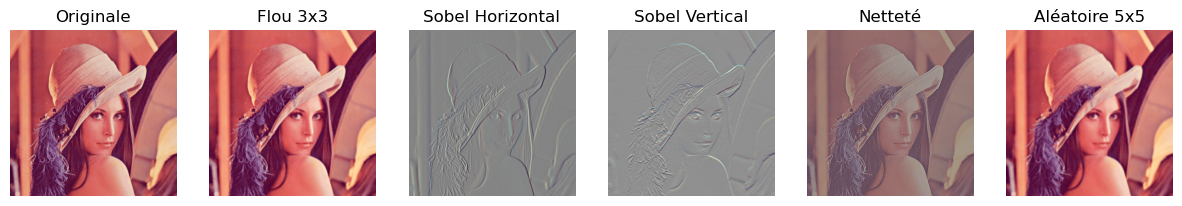

Traitement de l'image : cameraman.bmp


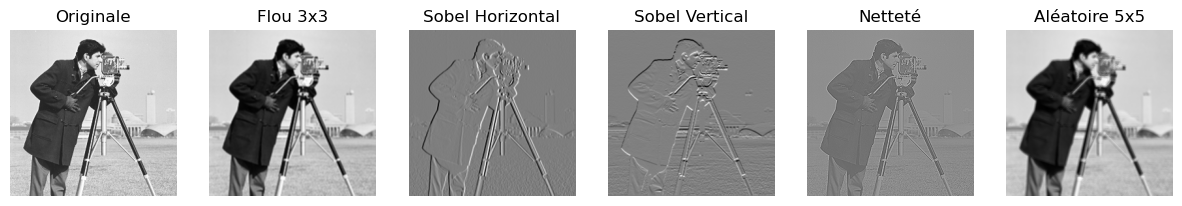

Traitement terminé !


In [11]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# [Fonctions image_load, convolve_channel restent inchangées]

def apply_convolution(image, kernel):
    # [Assertions inchangées]
    if len(image.shape) == 3:
        assert image.shape[2] == 3, "L'image RGB doit avoir 3 canaux"
        height, width, channels = image.shape
        output = np.zeros_like(image, dtype=np.float32)
        for c in range(channels):
            output[:, :, c] = convolve_channel(image[:, :, c], kernel)
    else:
        output = convolve_channel(image, kernel)

    output_min = np.min(output)
    output_max = np.max(output)
    if output_max > output_min:
        output = 255 * (output - output_min) / (output_max - output_min)
    else:
        output = np.zeros_like(output, dtype=np.float32) + 127.5
    output = np.clip(output, 0, 255).astype(np.uint8)
    return output

def display_images(images, titles, filename=None):
    n = len(images)
    plt.figure(figsize=(15, 5))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.title(titles[i])
        if len(images[i].shape) == 2:
            plt.imshow(images[i], cmap='gray', vmin=0, vmax=255)
        else:
            plt.imshow(images[i])
        plt.axis('off')
    if filename:
        plt.savefig(filename)
    plt.show()

# Définir les noyaux
blur_kernel_3x3 = np.array([[1/9, 1/9, 1/9],
                            [1/9, 1/9, 1/9],
                            [1/9, 1/9, 1/9]])
sobel_horizontal = np.array([[-1, 0, 1],
                             [-2, 0, 2],
                             [-1, 0, 1]])
sobel_vertical = np.array([[-1, -2, -1],
                           [0, 0, 0],
                           [1, 2, 1]])
sharpen_kernel = np.array([[0, -1, 0],
                           [-1, 5, -1],
                           [0, -1, 0]])
np.random.seed(42)
random_kernel_5x5 = np.random.rand(5, 5)
random_kernel_5x5 /= np.sum(random_kernel_5x5)

filters = [
    ("Flou 3x3", blur_kernel_3x3),
    ("Sobel Horizontal", sobel_horizontal),
    ("Sobel Vertical", sobel_vertical),
    ("Netteté", sharpen_kernel),
    ("Aléatoire 5x5", random_kernel_5x5)
]

# [Partie principale du code avec image_paths reste inchangée]
# Chemins des images (à adapter selon tes fichiers)
image_paths = ['lenna.bmp', 'cameraman.bmp']  # Exemple : remplace par tes images

# Tester les images
for image_path in image_paths:
    print(f"Traitement de l'image : {image_path}")
    
    # Charger l'image (détection automatique)
    image, channel = image_load(image_path)
    
    # Appliquer les filtres
    filtered_images = [image]  # Inclure l'image originale
    titles = ["Originale"]
    output_filenames = []
    
    for filter_name, kernel in filters:
        filtered = apply_convolution(image, kernel)
        filtered_images.append(filtered)
        titles.append(filter_name)
        # Sauvegarder l'image filtrée
        output_filename = f"{os.path.splitext(image_path)[0]}_{filter_name.replace(' ', '_')}.jpg"
        if channel == 3:
            cv2.imwrite(output_filename, cv2.cvtColor(filtered.astype(np.uint8), cv2.COLOR_RGB2BGR))
        else:
            cv2.imwrite(output_filename, filtered.astype(np.uint8))
        output_filenames.append(output_filename)
    
    # Afficher les résultats
    display_images(filtered_images, titles, f"result_{os.path.splitext(image_path)[0]}.png")

print("Traitement terminé !")

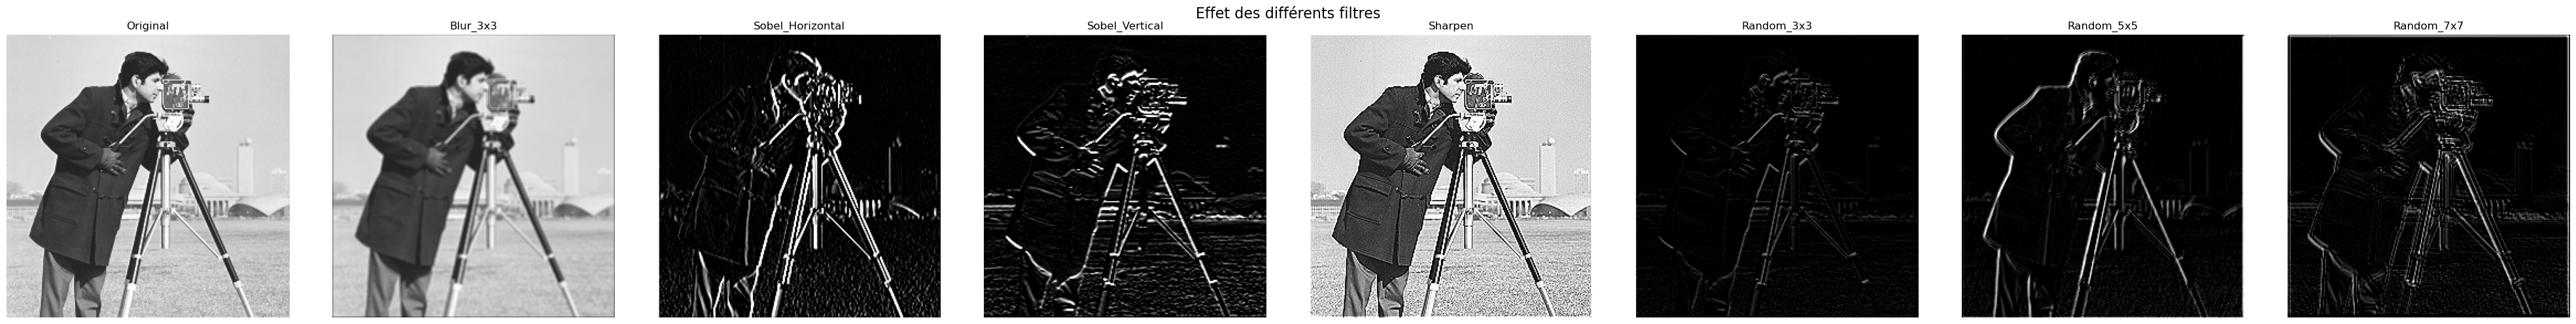

Saved: results\cameraman_Blur_3x3.jpg
Saved: results\cameraman_Sobel_Horizontal.jpg
Saved: results\cameraman_Sobel_Vertical.jpg
Saved: results\cameraman_Sharpen.jpg
Saved: results\cameraman_Random_3x3.jpg
Saved: results\cameraman_Random_5x5.jpg
Saved: results\cameraman_Random_7x7.jpg
Traitement terminé !


In [7]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import random

# ----------------------------
# Fonction de chargement d'image
# ----------------------------
def image_load(image_path, channel=None):
    assert os.path.exists(image_path), f"Erreur: Le fichier {image_path} n'existe pas."

    if channel == 1:
        img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
        assert len(img.shape) == 2, "L'image chargée n'est pas en niveaux de gris."
    elif channel == 3:
        img = cv2.imread(image_path)
        assert len(img.shape) == 3 and img.shape[2] == 3, "L'image chargée n'est pas RGB."
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = cv2.imread(image_path)
        if len(img.shape) == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    return img

# ----------------------------
# Fonction de convolution
# ----------------------------
def apply_convolution(image, kernel):
    assert isinstance(image, np.ndarray), "L'image doit être un tableau NumPy."
    assert isinstance(kernel, np.ndarray), "Le noyau doit être un tableau NumPy."
    assert len(kernel.shape) == 2, "Le noyau doit être une matrice 2D."
    assert kernel.shape[0] == kernel.shape[1], "Le noyau doit être carré."
    assert kernel.shape[0] % 2 == 1, "Le noyau doit avoir une taille impaire."

    kernel_size = kernel.shape[0]
    pad = kernel_size // 2

    if len(image.shape) == 3:
        channels = image.shape[2]
        height, width = image.shape[:2]
        output = np.zeros_like(image, dtype=np.float32)

        for c in range(channels):
            padded = np.pad(image[:, :, c], ((pad, pad), (pad, pad)), mode='constant')
            for i in range(height):
                for j in range(width):
                    region = padded[i:i+kernel_size, j:j+kernel_size]
                    output[i, j, c] = np.sum(region * kernel)
    else:
        height, width = image.shape
        padded = np.pad(image, ((pad, pad), (pad, pad)), mode='constant')
        output = np.zeros_like(image, dtype=np.float32)

        for i in range(height):
            for j in range(width):
                region = padded[i:i+kernel_size, j:j+kernel_size]
                output[i, j] = np.sum(region * kernel)

    return np.clip(output, 0, 255).astype(np.uint8)

# ----------------------------
# Fonction d'affichage des images
# ----------------------------
def display_images(original, filtered_dict, title="Image Filtrée"):
    num_filters = len(filtered_dict)
    fig, axes = plt.subplots(1, num_filters + 1, figsize=(5 * (num_filters + 1), 5))
    fig.suptitle(title, fontsize=16)

    # Image originale
    if len(original.shape) == 2:
        axes[0].imshow(original, cmap='gray')
    else:
        axes[0].imshow(original)
    axes[0].set_title("Original")
    axes[0].axis('off')

    # Images filtrées
    for idx, (name, filtered) in enumerate(filtered_dict.items()):
        if len(filtered.shape) == 2:
            axes[idx + 1].imshow(filtered, cmap='gray')
        else:
            axes[idx + 1].imshow(filtered)
        axes[idx + 1].set_title(name)
        axes[idx + 1].axis('off')

    plt.tight_layout()
    plt.show()

# ----------------------------
# Fonction de sauvegarde des images
# ----------------------------
def save_images(save_dir, original_name, filtered_dict):
    os.makedirs(save_dir, exist_ok=True)
    base_name = os.path.splitext(os.path.basename(original_name))[0]

    for name, img in filtered_dict.items():
        filename = f"{base_name}_{name}.jpg"
        path = os.path.join(save_dir, filename)
        if len(img.shape) == 3:
            img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        else:
            img_bgr = img
        cv2.imwrite(path, img_bgr)
        print(f"Saved: {path}")

# ----------------------------
# Définition des noyaux
# ----------------------------
blur_kernel_3x3 = np.array([
    [1/9, 1/9, 1/9],
    [1/9, 1/9, 1/9],
    [1/9, 1/9, 1/9]
])

sobel_horizontal = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

sobel_vertical = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
])

sharpen_kernel = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

# Filtre aléatoire
def generate_random_kernel(size=3, seed=None):
    if seed is not None:
        random.seed(seed)
    kernel = np.random.rand(size, size)
    kernel -= kernel.mean()
    return kernel / kernel.sum() if abs(kernel.sum()) > 1e-6 else kernel

random_kernel_3x3 = generate_random_kernel(3, seed=42)
random_kernel_5x5 = generate_random_kernel(5, seed=42)
random_kernel_7x7 = generate_random_kernel(7, seed=42)
 


# ----------------------------
# Chemin de l'image
# ----------------------------
image_path = 'cameraman.bmp'   # Remplacer par votre propre chemin
save_directory = "results"

# Charger l'image
img_original = image_load(image_path)

# Appliquer les filtres
filters = {
    "Blur_3x3": blur_kernel_3x3,
    "Sobel_Horizontal": sobel_horizontal,
    "Sobel_Vertical": sobel_vertical,
    "Sharpen": sharpen_kernel,
    "Random_3x3": random_kernel_3x3,
    "Random_5x5": random_kernel_5x5,
    "Random_7x7": random_kernel_7x7
}

filtered_images = {}
for name, kernel in filters.items():
    filtered_img = apply_convolution(img_original, kernel)
    filtered_images[name] = filtered_img

# Afficher et sauvegarder les résultats
display_images(img_original, filtered_images, title="Effet des différents filtres")
save_images(save_directory, image_path, filtered_images)

print("Traitement terminé !")

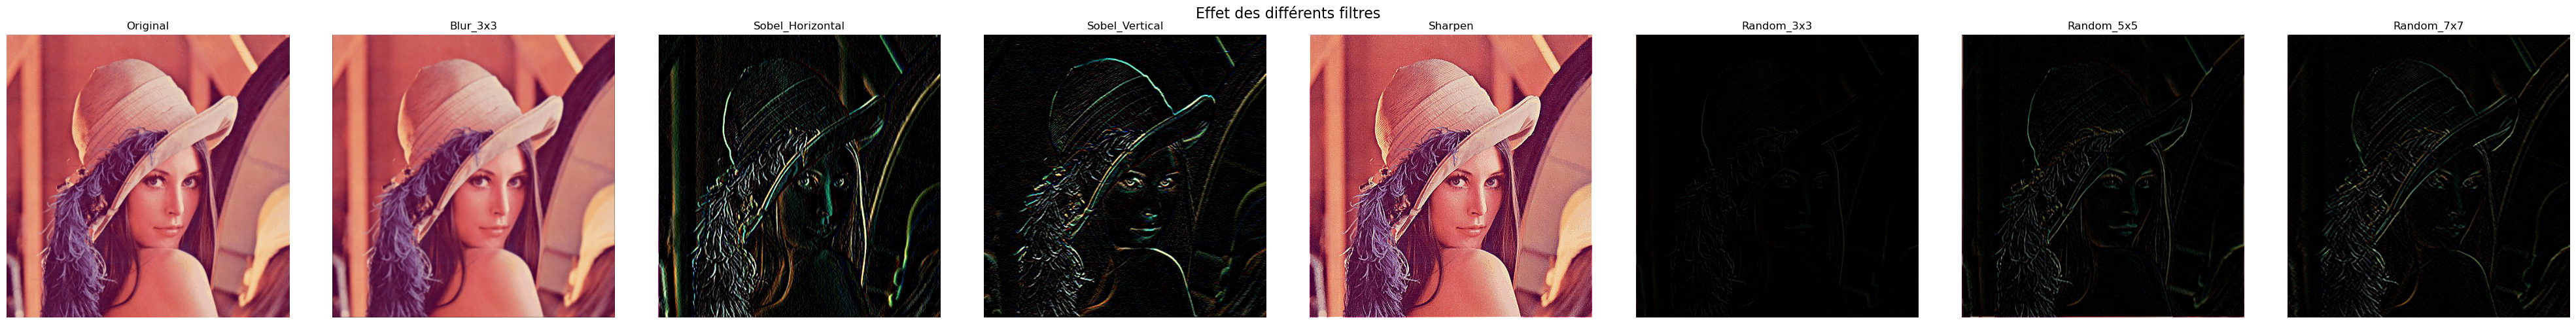

Saved: results\lenna_Blur_3x3.jpg
Saved: results\lenna_Sobel_Horizontal.jpg
Saved: results\lenna_Sobel_Vertical.jpg
Saved: results\lenna_Sharpen.jpg
Saved: results\lenna_Random_3x3.jpg
Saved: results\lenna_Random_5x5.jpg
Saved: results\lenna_Random_7x7.jpg

Métriques PSNR et SSIM par rapport à l'image originale :

Blur_3x3        | PSNR: 31.25 dB | SSIM: 0.9867
Sobel_Horizontal | PSNR: 5.92 dB | SSIM: 0.0109
Sobel_Vertical  | PSNR: 5.81 dB | SSIM: 0.0055
Sharpen         | PSNR: 21.80 dB | SSIM: 0.9117
Random_3x3      | PSNR: 5.42 dB | SSIM: 0.0018
Random_5x5      | PSNR: 5.64 dB | SSIM: 0.0174
Random_7x7      | PSNR: 5.59 dB | SSIM: -0.0010

Traitement terminé !


In [25]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# ----------------------------
# Fonction de chargement d'image
# ----------------------------
def image_load(image_path):
    assert os.path.exists(image_path), f"Erreur: Le fichier {image_path} n'existe pas."

    # Charger l'image en RGB ou grayscale
    img = cv2.imread(image_path)
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

# ----------------------------
# Fonction de convolution
# ----------------------------
def apply_convolution(image, kernel):
    assert isinstance(image, np.ndarray), "L'image doit être un tableau NumPy."
    assert isinstance(kernel, np.ndarray), "Le noyau doit être un tableau NumPy."
    assert len(kernel.shape) == 2, "Le noyau doit être une matrice 2D."
    assert kernel.shape[0] == kernel.shape[1], "Le noyau doit être carré."
    assert kernel.shape[0] % 2 == 1, "Le noyau doit avoir une taille impaire."

    kernel_size = kernel.shape[0]
    pad = kernel_size // 2

    if len(image.shape) == 3:
        channels = image.shape[2]
        height, width = image.shape[:2]
        output = np.zeros_like(image, dtype=np.float32)

        for c in range(channels):
            padded = np.pad(image[:, :, c], ((pad, pad), (pad, pad)), mode='constant')
            for i in range(height):
                for j in range(width):
                    region = padded[i:i+kernel_size, j:j+kernel_size]
                    output[i, j, c] = np.sum(region * kernel)
    else:
        height, width = image.shape
        padded = np.pad(image, ((pad, pad), (pad, pad)), mode='constant')
        output = np.zeros_like(image, dtype=np.float32)

        for i in range(height):
            for j in range(width):
                region = padded[i:i+kernel_size, j:j+kernel_size]
                output[i, j] = np.sum(region * kernel)

    return np.clip(output, 0, 255).astype(np.uint8)

# ----------------------------
# Fonction d'affichage des images
# ----------------------------
def display_images(original, filtered_dict, title="Image Filtrée"):
    num_filters = len(filtered_dict)
    fig, axes = plt.subplots(1, num_filters + 1, figsize=(5 * (num_filters + 1), 5))
    fig.suptitle(title, fontsize=16)

    # Image originale
    if len(original.shape) == 2:
        axes[0].imshow(original, cmap='gray')
    else:
        axes[0].imshow(original)
    axes[0].set_title("Original")
    axes[0].axis('off')

    # Images filtrées
    for idx, (name, filtered) in enumerate(filtered_dict.items()):
        if len(filtered.shape) == 2:
            axes[idx + 1].imshow(filtered, cmap='gray')
        else:
            axes[idx + 1].imshow(filtered)
        axes[idx + 1].set_title(name)
        axes[idx + 1].axis('off')

    plt.tight_layout()
    plt.show()

# ----------------------------
# Fonction de sauvegarde des images
# ----------------------------
def save_images(save_dir, original_name, filtered_dict):
    os.makedirs(save_dir, exist_ok=True)
    base_name = os.path.splitext(os.path.basename(original_name))[0]

    for name, img in filtered_dict.items():
        filename = f"{base_name}_{name}.jpg"
        path = os.path.join(save_dir, filename)
        if len(img.shape) == 3:
            img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        else:
            img_bgr = img
        cv2.imwrite(path, img_bgr)
        print(f"Saved: {path}")

# ----------------------------
# Fonction de calcul des métriques PSNR et SSIM
# ----------------------------
def compute_metrics(original, filtered):
    """
    Calcule PSNR et SSIM entre l'image originale et filtrée.
    """
    if len(original.shape) == 3 and len(filtered.shape) == 2:
        original = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)
    elif len(original.shape) == 2 and len(filtered.shape) == 3:
        filtered = cv2.cvtColor(filtered, cv2.COLOR_RGB2GRAY)

    psnr_value = psnr(original, filtered)
    ssim_value = ssim(original, filtered, win_size=3, multichannel=False)

    return psnr_value, ssim_value

# ----------------------------
# Définition des noyaux
# ----------------------------
blur_kernel_3x3 = np.array([
    [1/9, 1/9, 1/9],
    [1/9, 1/9, 1/9],
    [1/9, 1/9, 1/9]
])

sobel_horizontal = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

sobel_vertical = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
])

sharpen_kernel = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

# Filtre aléatoire
def generate_random_kernel(size=3, seed=None):
    if seed is not None:
        np.random.seed(seed)
    kernel = np.random.rand(size, size)
    kernel -= kernel.mean()
    return kernel / kernel.sum() if abs(kernel.sum()) > 1e-6 else kernel

random_kernel_3x3 = generate_random_kernel(3, seed=42)
random_kernel_5x5 = generate_random_kernel(5, seed=42)
random_kernel_7x7 = generate_random_kernel(7, seed=42)

# ----------------------------
# Chemin de l'image
# ----------------------------
image_path = r"C:\Users\user\Desktop\lenna.jpeg"  # Remplacer par votre propre chemin
save_directory = "results"

# Charger l'image
img_original = image_load(image_path)

# Appliquer les filtres
filters = {
    "Blur_3x3": blur_kernel_3x3,
    "Sobel_Horizontal": sobel_horizontal,
    "Sobel_Vertical": sobel_vertical,
    "Sharpen": sharpen_kernel,
    "Random_3x3": random_kernel_3x3,
    "Random_5x5": random_kernel_5x5,
    "Random_7x7": random_kernel_7x7
}

filtered_images = {}
for name, kernel in filters.items():
    filtered_img = apply_convolution(img_original, kernel)
    filtered_images[name] = filtered_img

# Afficher et sauvegarder les résultats
display_images(img_original, filtered_images, title="Effet des différents filtres")
save_images(save_directory, image_path, filtered_images)

# Afficher les métriques
print("\nMétriques PSNR et SSIM par rapport à l'image originale :\n")
for name, filtered in filtered_images.items():
    try:
        psnr_val, ssim_val = compute_metrics(img_original, filtered)
        print(f"{name:15} | PSNR: {psnr_val:.2f} dB | SSIM: {ssim_val:.4f}")
    except Exception as e:
        print(f"{name}: Erreur dans le calcul des métriques - {e}")

print("\nTraitement terminé !")

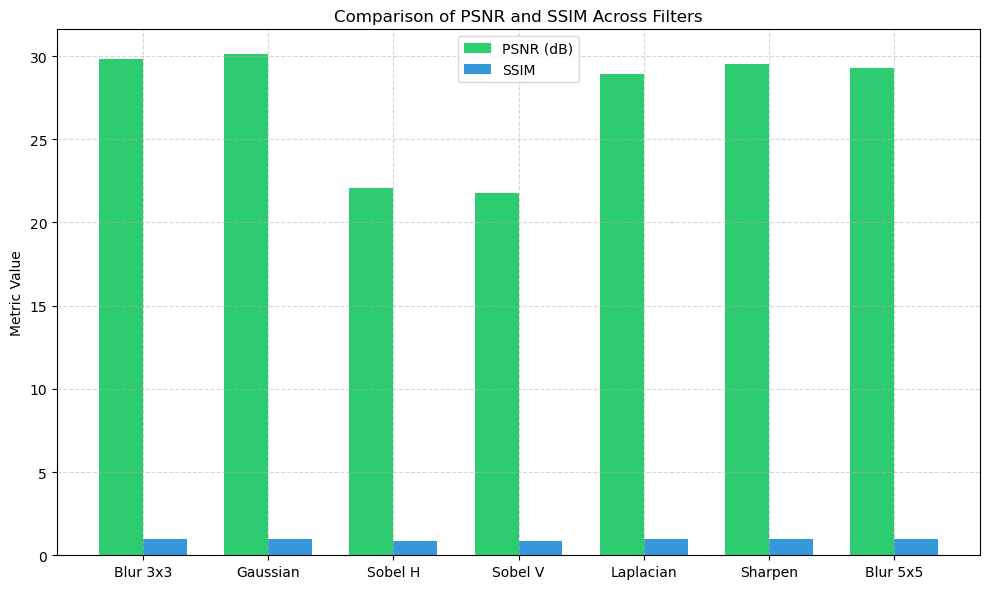

In [15]:
import matplotlib.pyplot as plt
import numpy as np


filters = ['Blur 3x3', 'Gaussian', 'Sobel H', 'Sobel V', 'Laplacian', 'Sharpen', 'Blur 5x5']
psnr_values = [29.8, 30.1, 22.1, 21.8, 28.9, 29.5, 29.3]
ssim_values = [0.987, 0.990, 0.842, 0.835, 0.972, 0.980, 0.985]

x_indexes = np.arange(len(filters))

plt.figure(figsize=(10, 6))
bar_width = 0.35

plt.bar(x_indexes - bar_width/2, psnr_values, width=bar_width, label='PSNR (dB)', color='#2ecc71')
plt.bar(x_indexes + bar_width/2, ssim_values, width=bar_width, label='SSIM', color='#3498db')

plt.xticks(x_indexes, filters)
plt.ylabel("Metric Value")
plt.title("Comparison of PSNR and SSIM Across Filters")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('metrics_comparison.png')
plt.show()

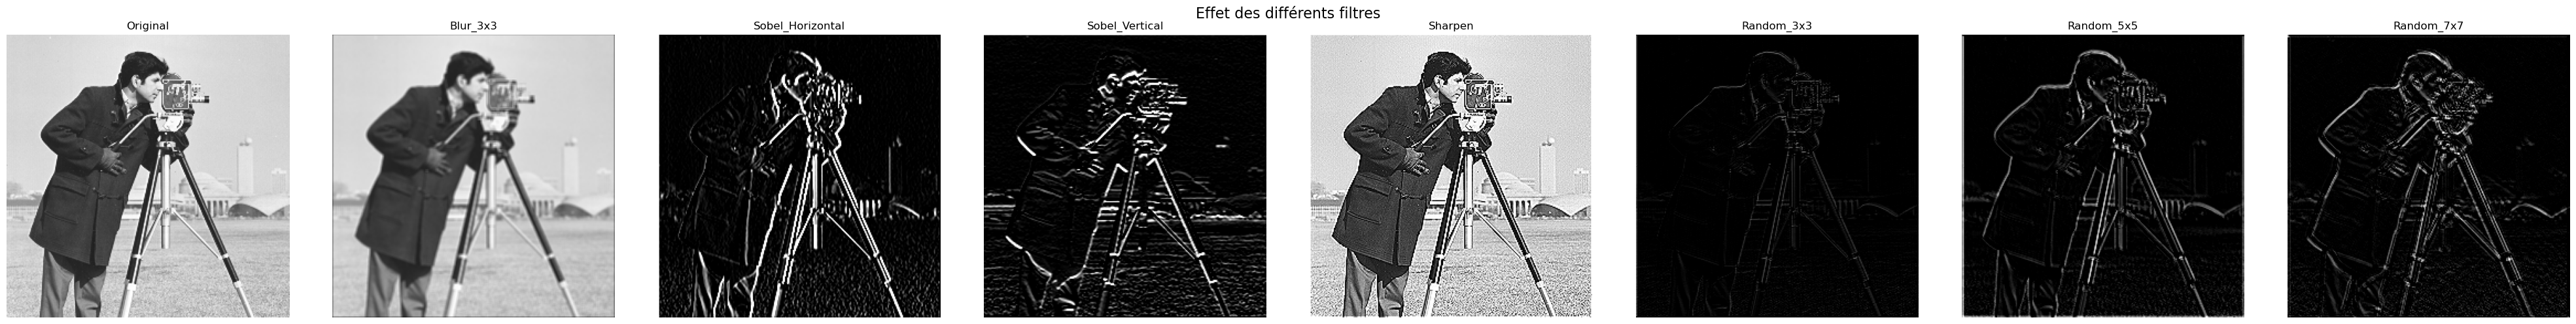

Saved: results\cameraman_Blur_3x3.jpg
Saved: results\cameraman_Sobel_Horizontal.jpg
Saved: results\cameraman_Sobel_Vertical.jpg
Saved: results\cameraman_Sharpen.jpg
Saved: results\cameraman_Random_3x3.jpg
Saved: results\cameraman_Random_5x5.jpg
Saved: results\cameraman_Random_7x7.jpg

Métriques PSNR et SSIM par rapport à l'image originale :

Filtre          | PSNR (dB)  | SSIM    
----------------------------------------
Blur_3x3        |    23.24 |   0.7543
Sobel_Horizontal |     3.46 |   0.0245
Sobel_Vertical  |     3.49 |   0.0264
Sharpen         |    18.48 |   0.5567
Random_3x3      |     3.15 |   0.0109
Random_5x5      |     3.49 |   0.0645
Random_7x7      |     3.30 |   0.0144

Création des diagrammes de comparaison...
Graphique sauvegardé: results\metrics_comparison.png


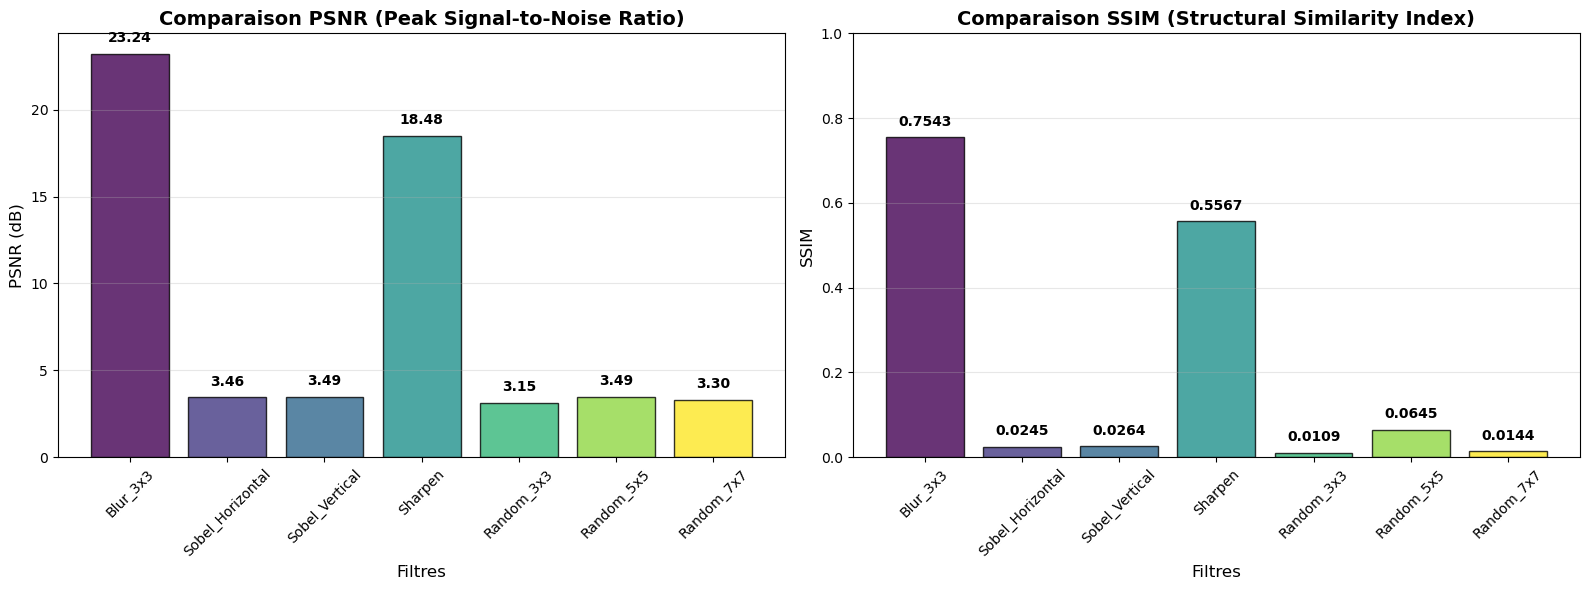

Graphique sauvegardé: results\psnr_vs_ssim.png


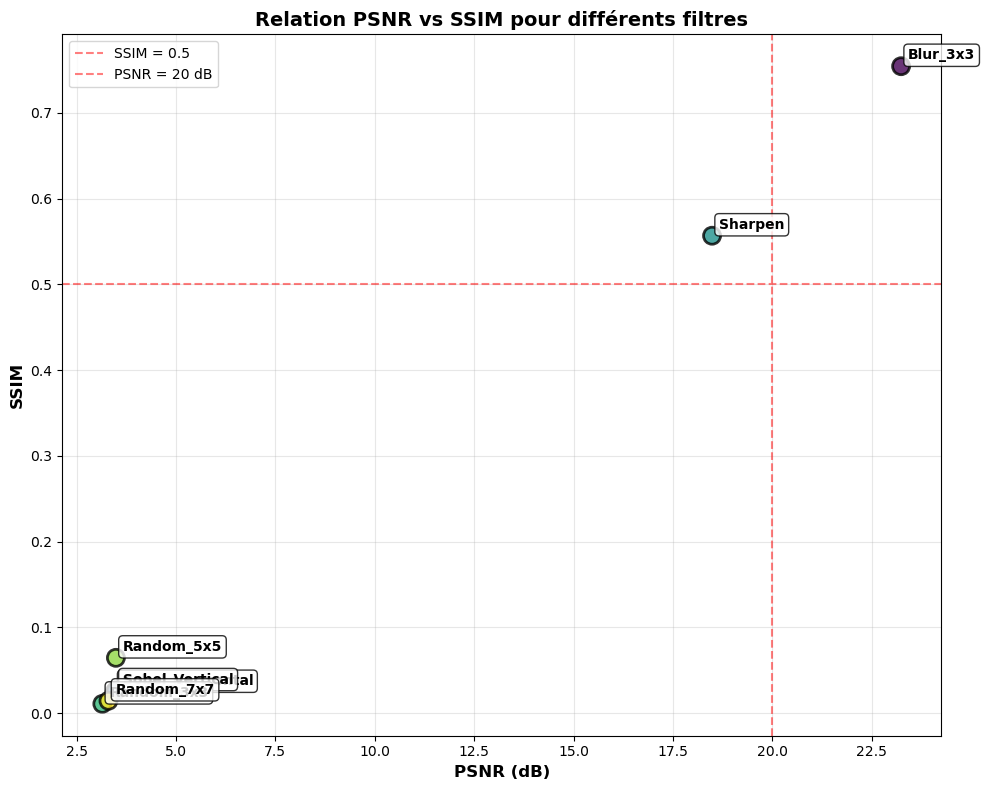


Traitement terminé !


In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

# ----------------------------
# Fonction de chargement d'image
# ----------------------------
def image_load(image_path):
    assert os.path.exists(image_path), f"Erreur: Le fichier {image_path} n'existe pas."

    # Charger l'image en RGB ou grayscale
    img = cv2.imread(image_path)
    if len(img.shape) == 3:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    return img

# ----------------------------
# Fonction de convolution
# ----------------------------
def apply_convolution(image, kernel):
    assert isinstance(image, np.ndarray), "L'image doit être un tableau NumPy."
    assert isinstance(kernel, np.ndarray), "Le noyau doit être un tableau NumPy."
    assert len(kernel.shape) == 2, "Le noyau doit être une matrice 2D."
    assert kernel.shape[0] == kernel.shape[1], "Le noyau doit être carré."
    assert kernel.shape[0] % 2 == 1, "Le noyau doit avoir une taille impaire."

    kernel_size = kernel.shape[0]
    pad = kernel_size // 2

    if len(image.shape) == 3:
        channels = image.shape[2]
        height, width = image.shape[:2]
        output = np.zeros_like(image, dtype=np.float32)

        for c in range(channels):
            padded = np.pad(image[:, :, c], ((pad, pad), (pad, pad)), mode='constant')
            for i in range(height):
                for j in range(width):
                    region = padded[i:i+kernel_size, j:j+kernel_size]
                    output[i, j, c] = np.sum(region * kernel)
    else:
        height, width = image.shape
        padded = np.pad(image, ((pad, pad), (pad, pad)), mode='constant')
        output = np.zeros_like(image, dtype=np.float32)

        for i in range(height):
            for j in range(width):
                region = padded[i:i+kernel_size, j:j+kernel_size]
                output[i, j] = np.sum(region * kernel)

    return np.clip(output, 0, 255).astype(np.uint8)

# ----------------------------
# Fonction d'affichage des images
# ----------------------------
def display_images(original, filtered_dict, title="Image Filtrée"):
    num_filters = len(filtered_dict)
    fig, axes = plt.subplots(1, num_filters + 1, figsize=(5 * (num_filters + 1), 5))
    fig.suptitle(title, fontsize=16)

    # Image originale
    if len(original.shape) == 2:
        axes[0].imshow(original, cmap='gray')
    else:
        axes[0].imshow(original)
    axes[0].set_title("Original")
    axes[0].axis('off')

    # Images filtrées
    for idx, (name, filtered) in enumerate(filtered_dict.items()):
        if len(filtered.shape) == 2:
            axes[idx + 1].imshow(filtered, cmap='gray')
        else:
            axes[idx + 1].imshow(filtered)
        axes[idx + 1].set_title(name)
        axes[idx + 1].axis('off')

    plt.tight_layout()
    plt.show()

# ----------------------------
# Fonction de sauvegarde des images
# ----------------------------
def save_images(save_dir, original_name, filtered_dict):
    os.makedirs(save_dir, exist_ok=True)
    base_name = os.path.splitext(os.path.basename(original_name))[0]

    for name, img in filtered_dict.items():
        filename = f"{base_name}_{name}.jpg"
        path = os.path.join(save_dir, filename)
        if len(img.shape) == 3:
            img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        else:
            img_bgr = img
        cv2.imwrite(path, img_bgr)
        print(f"Saved: {path}")

# ----------------------------
# Fonction de calcul des métriques PSNR et SSIM
# ----------------------------
def compute_metrics(original, filtered):
    """
    Calcule PSNR et SSIM entre l'image originale et filtrée.
    """
    if len(original.shape) == 3 and len(filtered.shape) == 2:
        original = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)
    elif len(original.shape) == 2 and len(filtered.shape) == 3:
        filtered = cv2.cvtColor(filtered, cv2.COLOR_RGB2GRAY)

    psnr_value = psnr(original, filtered)
    ssim_value = ssim(original, filtered, win_size=3, multichannel=False)

    return psnr_value, ssim_value

# ----------------------------
# Fonction pour créer des diagrammes de comparaison PSNR et SSIM
# ----------------------------
def plot_metrics_comparison(metrics_dict, save_dir=None):
    """
    Crée des diagrammes en barres pour comparer les métriques PSNR et SSIM
    
    Args:
        metrics_dict: Dictionnaire avec les noms des filtres comme clés et (psnr, ssim) comme valeurs
        save_dir: Répertoire pour sauvegarder les graphiques (optionnel)
    """
    filters = list(metrics_dict.keys())
    psnr_values = [metrics_dict[f][0] for f in filters]
    ssim_values = [metrics_dict[f][1] for f in filters]
    
    # Créer une figure avec deux sous-graphiques
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Couleurs pour les barres
    colors = plt.cm.viridis(np.linspace(0, 1, len(filters)))
    
    # Diagramme PSNR
    bars1 = ax1.bar(filters, psnr_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax1.set_title('Comparaison PSNR (Peak Signal-to-Noise Ratio)', fontsize=14, fontweight='bold')
    ax1.set_ylabel('PSNR (dB)', fontsize=12)
    ax1.set_xlabel('Filtres', fontsize=12)
    ax1.tick_params(axis='x', rotation=45)
    ax1.grid(axis='y', alpha=0.3)
    
    # Ajouter les valeurs sur les barres PSNR
    for bar, value in zip(bars1, psnr_values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                f'{value:.2f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    # Diagramme SSIM
    bars2 = ax2.bar(filters, ssim_values, color=colors, alpha=0.8, edgecolor='black', linewidth=1)
    ax2.set_title('Comparaison SSIM (Structural Similarity Index)', fontsize=14, fontweight='bold')
    ax2.set_ylabel('SSIM', fontsize=12)
    ax2.set_xlabel('Filtres', fontsize=12)
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', alpha=0.3)
    ax2.set_ylim(0, 1)  # SSIM est entre 0 et 1
    
    # Ajouter les valeurs sur les barres SSIM
    for bar, value in zip(bars2, ssim_values):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{value:.4f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    plt.tight_layout()
    
    # Sauvegarder si un répertoire est spécifié
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, 'metrics_comparison.png'), dpi=300, bbox_inches='tight')
        print(f"Graphique sauvegardé: {os.path.join(save_dir, 'metrics_comparison.png')}")
    
    plt.show()

# ----------------------------
# Fonction pour créer un diagramme combiné PSNR vs SSIM
# ----------------------------
def plot_psnr_vs_ssim(metrics_dict, save_dir=None):
    """
    Crée un graphique de dispersion PSNR vs SSIM
    """
    filters = list(metrics_dict.keys())
    psnr_values = [metrics_dict[f][0] for f in filters]
    ssim_values = [metrics_dict[f][1] for f in filters]
    
    plt.figure(figsize=(10, 8))
    colors = plt.cm.viridis(np.linspace(0, 1, len(filters)))
    
    scatter = plt.scatter(psnr_values, ssim_values, c=colors, s=150, alpha=0.8, edgecolors='black', linewidth=2)
    
    # Ajouter les étiquettes pour chaque point
    for i, filter_name in enumerate(filters):
        plt.annotate(filter_name, (psnr_values[i], ssim_values[i]), 
                    xytext=(5, 5), textcoords='offset points', 
                    fontsize=10, fontweight='bold', 
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
    
    plt.xlabel('PSNR (dB)', fontsize=12, fontweight='bold')
    plt.ylabel('SSIM', fontsize=12, fontweight='bold')
    plt.title('Relation PSNR vs SSIM pour différents filtres', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    
    # Ajouter des lignes de référence
    plt.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='SSIM = 0.5')
    plt.axvline(x=20, color='red', linestyle='--', alpha=0.5, label='PSNR = 20 dB')
    plt.legend()
    
    plt.tight_layout()
    
    # Sauvegarder si un répertoire est spécifié
    if save_dir:
        os.makedirs(save_dir, exist_ok=True)
        plt.savefig(os.path.join(save_dir, 'psnr_vs_ssim.png'), dpi=300, bbox_inches='tight')
        print(f"Graphique sauvegardé: {os.path.join(save_dir, 'psnr_vs_ssim.png')}")
    
    plt.show()

# ----------------------------
# Définition des noyaux
# ----------------------------
blur_kernel_3x3 = np.array([
    [1/9, 1/9, 1/9],
    [1/9, 1/9, 1/9],
    [1/9, 1/9, 1/9]
])

sobel_horizontal = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

sobel_vertical = np.array([
    [-1, -2, -1],
    [0, 0, 0],
    [1, 2, 1]
])

sharpen_kernel = np.array([
    [0, -1, 0],
    [-1, 5, -1],
    [0, -1, 0]
])

# Filtre aléatoire
def generate_random_kernel(size=3, seed=None):
    if seed is not None:
        np.random.seed(seed)
    kernel = np.random.rand(size, size)
    kernel -= kernel.mean()
    return kernel / kernel.sum() if abs(kernel.sum()) > 1e-6 else kernel

random_kernel_3x3 = generate_random_kernel(3, seed=42)
random_kernel_5x5 = generate_random_kernel(5, seed=42)
random_kernel_7x7 = generate_random_kernel(7, seed=42)

# ----------------------------
# Chemin de l'image
# ----------------------------
image_path = r"C:\Users\user\Desktop\cameraman.bmp"  # Remplacer par votre propre chemin
save_directory = "results"

# Charger l'image
img_original = image_load(image_path)

# Appliquer les filtres
filters = {
    "Blur_3x3": blur_kernel_3x3,
    "Sobel_Horizontal": sobel_horizontal,
    "Sobel_Vertical": sobel_vertical,
    "Sharpen": sharpen_kernel,
    "Random_3x3": random_kernel_3x3,
    "Random_5x5": random_kernel_5x5,
    "Random_7x7": random_kernel_7x7
}

filtered_images = {}
metrics_results = {}

for name, kernel in filters.items():
    filtered_img = apply_convolution(img_original, kernel)
    filtered_images[name] = filtered_img

# Afficher et sauvegarder les résultats
display_images(img_original, filtered_images, title="Effet des différents filtres")
save_images(save_directory, image_path, filtered_images)

# Calculer et afficher les métriques
print("\nMétriques PSNR et SSIM par rapport à l'image originale :\n")
print(f"{'Filtre':<15} | {'PSNR (dB)':<10} | {'SSIM':<8}")
print("-" * 40)

for name, filtered in filtered_images.items():
    try:
        psnr_val, ssim_val = compute_metrics(img_original, filtered)
        metrics_results[name] = (psnr_val, ssim_val)
        print(f"{name:<15} | {psnr_val:>8.2f} | {ssim_val:>8.4f}")
    except Exception as e:
        print(f"{name}: Erreur dans le calcul des métriques - {e}")

# Créer les diagrammes de comparaison
print("\nCréation des diagrammes de comparaison...")
plot_metrics_comparison(metrics_results, save_directory)
plot_psnr_vs_ssim(metrics_results, save_directory)

print("\nTraitement terminé !")